<a href="https://colab.research.google.com/github/alvinkimbowa/low-field-mri/blob/main/Code/3T_Denoising_using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtain the image data from drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!ln -s '/content/drive/My Drive/Low Field MRI' /mydrive

Mounted at /content/drive


In [3]:
import os

# Low-Field MRI Data
print("Copying low field MRI data (axial 60 dataset)...")
dst = 'axial_10days_images'
if os.path.exists(dst):
    !rm -r "{dst}"
!cp -r "/mydrive/Datasets/SG Data/{dst}.zip" "/content"
!unzip -o -q 'axial_10days_images.zip' -d '/content'
print("Done!")

# 3T data
print("Copying the high filed MRI data (IXI dataset)...")
!cp '/mydrive/Datasets/IXI Brain dataset/IXI-T2.tar' /content
dst = 'IXI-T2'
if os.path.exists(dst):
    !rm -r '{dst}'
!mkdir '{dst}'
!tar -xf "IXI-T2.tar" -C "{dst}"
print("Done!")

Copying low field MRI data (axial 60 dataset)...
Done!
Copying the high filed MRI data (IXI dataset)...
Done!


# Import necessary libraries

In [133]:
!pip install patchify -q

import keras
import random
import scipy.stats
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from pprint import pprint
from patchify import patchify
from skimage.util import view_as_blocks

# Preprocess data

In [201]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dist_params, batch_size=6, patch_size=(256,256), 
                 dim=(256,256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.dist_params = dist_params
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.patch_size = patch_size

        self.noise = self.__generate_noise(dist_params)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # print(list_IDs_temp)

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __generate_noise(self, dist_params):
        x = np.linspace(0, self.dim[0], self.dim[0]*self.dim[1])
        
        if dist_params['dist'] == 'gamma':
            a = dist_params['a']
            loc = dist_params['loc']
            scale = dist_params['scale']
            noise = scipy.stats.gamma.rvs(
                a=a, loc=loc, scale=scale, size=self.patch_size
                )
        
        noise = noise.reshape(*self.patch_size, self.n_channels)

        return noise


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # y = np.empty((self.batch_size, *self.dim, self.n_channels))
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X_tmp = nib.load(ID).get_fdata()
            X_tmp = np.moveaxis(X_tmp, -1, 0)
            X_tmp = view_as_blocks(X_tmp, block_shape=(X_tmp.shape[0], *patch_size))
            X_tmp = np.moveaxis(X_tmp, 3, 0).reshape(-1,*patch_size,1)

            # Add noise
            y_tmp = X_tmp + self.noise

            if len(X)>0 and len(y)>0:
                X = np.concatenate((X, X_tmp), axis=0)
                y = np.concatenate((y, y_tmp))
            else:
                X = X_tmp
                y = y_tmp

        X = np.asarray(X)
        y = np.asarray(y)
        return X, y

(256, 256) (16, 64, 64, 1)


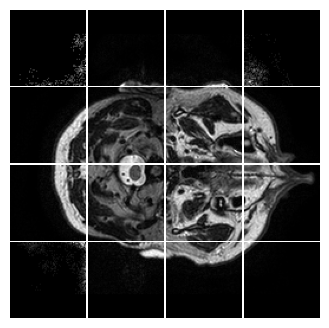

In [202]:
ID = "/content/IXI-T2/IXI016-Guys-0697-T2.nii.gz"

patch_size = (64, 64)
X_tmp = nib.load(ID).get_fdata()
X_tmp = np.moveaxis(X_tmp, -1, 0)
patches = view_as_blocks(X_tmp[0], block_shape=patch_size)
patches = patches.reshape(-1,*patch_size,1)
print(X_tmp[0].shape, patches.shape)

# plt.imshow(X_tmp[0], cmap='gray')
# plt.axis('off')
# plt.show()

# patch = X_tmp[0, :64, :64]
# plt.imshow(patch, cmap='gray')

fig = plt.figure(figsize=(4,4))
for i in range(patches.shape[0]):
    patch = patches[i]
    ax = fig.add_subplot(int(np.sqrt(patches.shape[0])), int(np.sqrt(patches.shape[0])),i+1)
    ax.imshow(patch, cmap='gray')
    ax.axis("off")

plt.subplots_adjust(hspace=0.02, wspace=0.02)

In [203]:
dist_params = {
    'dist': 'gamma',
    'a': 3.3,
    'loc': -4.47,
    'scale': 22.5
    }

data_folder = Path('IXI-T2')
ids = list(data_folder.glob('*'))
patch_size = (64,64)
batch_size = 1

train_gen = DataGenerator(ids, dist_params, batch_size=batch_size, patch_size=patch_size)

(2080, 64, 64, 1) (2080, 64, 64, 1)


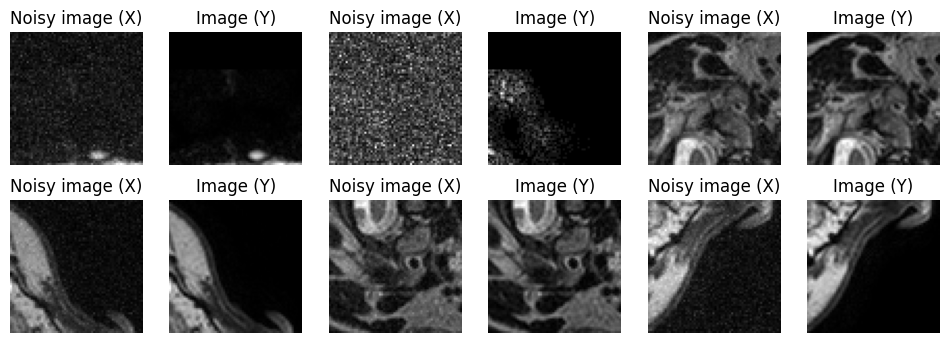

In [204]:
def plot_patches(generator):
    """ Function to display row of image patches """
    k = random.randint(0,len(generator))
    x, y = generator[k]
    print(x.shape, y.shape)

    fig = plt.figure(figsize=(12,4))

    for i in range(1,12,2):
        ax = fig.add_subplot(2,6,i)
        ax.imshow(y[i], cmap='gray')
        ax.set_title("Noisy image (X)")
        ax.axis('off')

        ax = fig.add_subplot(2,6,i+1)
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
        ax.set_title("Image (Y)")

    plt.show()

plot_patches(train_gen)

# Model definition